In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Importing Relevant Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Activation
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import os
import glob
import cv2
import json
# import splitfolders
import math
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

**Importing Data**

In [ ]:
train_path = 'gdrive/MyDrive/COVID-19_Radiography_Dataset/train/'

In [ ]:
'''
splitfolders.ratio('gdrive/MyDrive/COVID-19_Radiography_Dataset/COVID/', output='gdrive/MyDrive/COVID-19_Radiography_Dataset/', ratio=(0.7, 0.2, 0.1))
splitfolders.ratio('gdrive/MyDrive/COVID-19_Radiography_Dataset/Normal/', output='gdrive/MyDrive/COVID-19_Radiography_Dataset/', ratio=(0.7, 0.2, 0.1))
'''

"\nsplitfolders.ratio('gdrive/MyDrive/COVID-19_Radiography_Dataset/COVID/', output='gdrive/MyDrive/COVID-19_Radiography_Dataset/', ratio=(0.7, 0.2, 0.1))\nsplitfolders.ratio('gdrive/MyDrive/COVID-19_Radiography_Dataset/Normal/', output='gdrive/MyDrive/COVID-19_Radiography_Dataset/', ratio=(0.7, 0.2, 0.1))\n"

In [ ]:
metadata = pd.read_excel('gdrive/MyDrive/COVID-19_Radiography_Dataset/COVID_metadata.xlsx')

In [ ]:
metadata.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


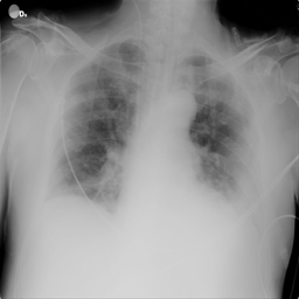

In [ ]:
Image.open('gdrive/MyDrive/COVID-19_Radiography_Dataset/COVID/data/COVID-1.png')

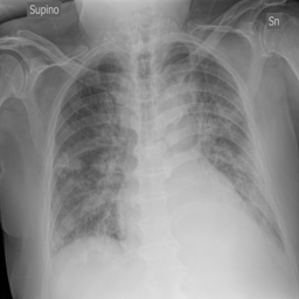

In [ ]:
Image.open('gdrive/MyDrive/COVID-19_Radiography_Dataset/COVID/data/COVID-10.png')

In [ ]:
len(os.listdir(train_path))

2

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='gdrive/MyDrive/COVID-19_Radiography_Dataset/train/',
    labels='inferred',
    validation_split=0.44,
    seed = 1337,
    subset='training',
    image_size=(256,256),
    color_mode='rgb',
    batch_size=10
)

Found 9684 files belonging to 2 classes.
Using 5424 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory='gdrive/MyDrive/COVID-19_Radiography_Dataset/val/',
    labels='inferred',
    validation_split=0.86,
    seed = 1337,
    subset='validation',
    image_size=(256,256),
    color_mode='rgb',
    batch_size=10
)

Found 2766 files belonging to 2 classes.
Using 2378 files for validation.


**Preprocessing Raw Data**

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.44,
    fill_mode='nearest'
)

In [ ]:
datagen_val = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.86,
    fill_mode='nearest'
)

In [ ]:
datagen_test = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_generator = datagen_train.flow_from_directory(
    'gdrive/MyDrive/COVID-19_Radiography_Dataset/train/',
    subset='training',
    target_size=(256,256),
    batch_size=10,
    class_mode='binary',
    shuffle=False
)

Found 5424 images belonging to 2 classes.


In [ ]:
val_generator = datagen_val.flow_from_directory(
    'gdrive/MyDrive/COVID-19_Radiography_Dataset/val/',
    subset='validation',
    target_size=(256,256),
    batch_size=10,
    class_mode='binary',
    shuffle=False
)

Found 2377 images belonging to 2 classes.


In [ ]:
test_generator = datagen_test.flow_from_directory(
    'gdrive/MyDrive/COVID-19_Radiography_Dataset/test/',
    target_size=(256,256),
    batch_size=10,
    class_mode='binary',
    shuffle=False
)

Found 1385 images belonging to 2 classes.


**Building a Deep Learning Architecture**

To build our network, we will apply transfer learning --- using an existing pre-trained architecture for the first n layers of our network and adding in additional layers to it to make it specific to the binary classification task we are performing. For transfer learning, we will use the VGG16 model, which is a pre-trained architecture with 16 layers. To that, we add 4 additional layers (1 Flatten and 3 Dense layers) with the last layer using a sigmoid activation function due to our binary classification task.

In [ ]:
model_vgg16 = VGG16(include_top=False)

In [ ]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
input = Input(shape=(256,256,3), name='img_input')
output_vgg16 = model_vgg16(input)
x = Flatten(name='flatten')(output_vgg16)
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dense(512, activation='relu', name='fc2')(x)
x = Dense(1, activation='sigmoid', name='preds')(x)

In [ ]:
my_model = Model(inputs=input, outputs=x)
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 fc1 (Dense)                 (None, 1024)              33555456  
                                                                 
 fc2 (Dense)                 (None, 512)               524800    
                                                                 
 preds (Dense)               (None, 1)                 513       
                                                                 
Total params: 48,795,457
Trainable params: 48,795,457
Non-tra

In [ ]:
my_model.compile(
    optimizer='sgd',
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

**Training the Model**

In [ ]:
history = my_model.fit(
    train_generator,
    epochs=20
)

Epoch 1/20
543/543 [==============================] - 107s 188ms/step - loss: 0.6441 - accuracy: 0.7282
Epoch 2/20
543/543 [==============================] - 101s 187ms/step - loss: 0.5472 - accuracy: 0.7393
Epoch 3/20
543/543 [==============================] - 101s 185ms/step - loss: 0.4855 - accuracy: 0.7753
Epoch 4/20
543/543 [==============================] - 100s 185ms/step - loss: 0.4467 - accuracy: 0.8046
Epoch 5/20
543/543 [==============================] - 100s 184ms/step - loss: 0.4298 - accuracy: 0.8110
Epoch 6/20
543/543 [==============================] - 100s 184ms/step - loss: 0.3900 - accuracy: 0.8328
Epoch 7/20
543/543 [==============================] - 100s 185ms/step - loss: 0.3586 - accuracy: 0.8400
Epoch 8/20
543/543 [==============================] - 101s 185ms/step - loss: 0.3121 - accuracy: 0.8678
Epoch 9/20
543/543 [==============================] - 100s 184ms/step - loss: 0.2757 - accuracy: 0.8859
Epoch 10/20
543/543 [==============================] - 101s 185m

In [ ]:
print(history.history)

{'loss': [0.6440571546554565, 0.5472292304039001, 0.48549821972846985, 0.44673189520835876, 0.42975419759750366, 0.38997387886047363, 0.3586410582065582, 0.31207403540611267, 0.275703102350235, 0.2617935538291931, 0.2512803375720978, 0.2342829704284668, 0.20886968076229095, 0.18820008635520935, 0.18613964319229126, 0.17922236025333405, 0.15898115932941437, 0.15402504801750183, 0.1563328355550766, 0.12978744506835938], 'accuracy': [0.7282448410987854, 0.7393068075180054, 0.7752581238746643, 0.8045722842216492, 0.811025083065033, 0.8327802419662476, 0.8399705290794373, 0.8678097128868103, 0.8858776092529297, 0.8891961574554443, 0.8960176706314087, 0.907263994216919, 0.9159291982650757, 0.9251474738121033, 0.9277285933494568, 0.9275442361831665, 0.9358407258987427, 0.9400811195373535, 0.9391592741012573, 0.9528023600578308]}


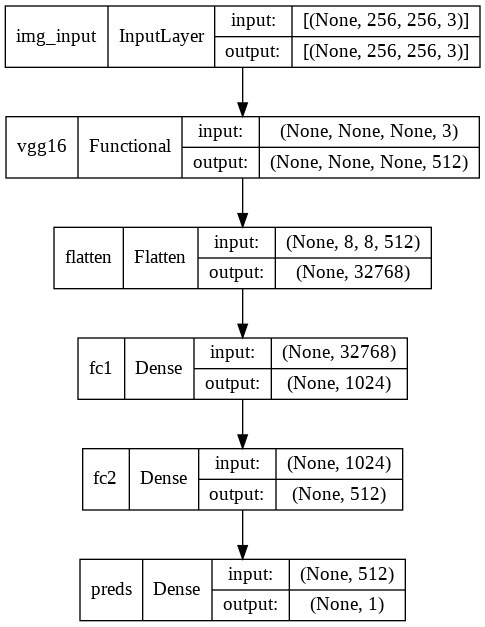

In [ ]:
plot_model(my_model, to_file='/my-model.png', show_shapes=True)

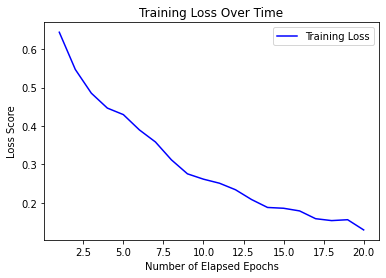

In [ ]:
training_loss = history.history['loss']
epochs = range(1,21)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Number of Elapsed Epochs')
plt.ylabel('Loss Score')
plt.legend()
plt.show()

In [ ]:
val_ds.class_names

['covid', 'normal']

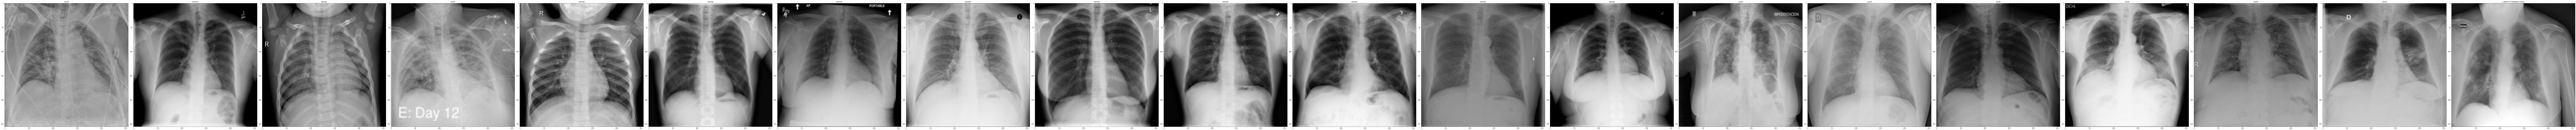

In [ ]:
test_imgs = np.zeros((1,256,256,3))
fig, axs = plt.subplots(1, 20, figsize=(256,256))
cnt = 0
for images, labels in val_ds.take(2):
    for i in range(10):
        test_img = images[i].numpy().astype("uint8")
        test_label = val_ds.class_names[labels[i]]
        if cnt < 10:
          axs[i].set_title(test_label)
          axs[i].imshow(test_img)
        else:
          axs[i+10].set_title(test_label)
          axs[i+10].imshow(test_img)
        test_img = test_img.reshape((1,) + test_img.shape)
        if cnt < 20: test_imgs = np.vstack((test_imgs, test_img))
        cnt += 1
test_imgs = test_imgs[1:]
fig.tight_layout()
plt.title('1 Batch of Validation Data')
plt.show()

In [ ]:
test_imgs.shape

(20, 256, 256, 3)

As shown above, the shape of each test image is (256, 256, 3); the image is of shape (256,256) and has 3 RGB channels. The 20 for the first dimension represents the 20 images that we are testing and displaying above.

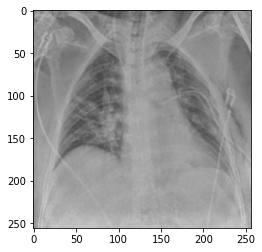

In [ ]:
test_img = test_imgs[0,:,:,:]
test_img = test_img.astype("uint8").reshape((1,) + test_img.shape)
plt.imshow(test_img[0])

In [ ]:
test_imgs

array([[[[111., 111., 111.],
         [113., 113., 113.],
         [114., 114., 114.],
         ...,
         [157., 157., 157.],
         [146., 146., 146.],
         [135., 135., 135.]],

        [[112., 112., 112.],
         [114., 114., 114.],
         [125., 125., 125.],
         ...,
         [151., 151., 151.],
         [150., 150., 150.],
         [146., 146., 146.]],

        [[112., 112., 112.],
         [121., 121., 121.],
         [141., 141., 141.],
         ...,
         [147., 147., 147.],
         [149., 149., 149.],
         [157., 157., 157.]],

        ...,

        [[143., 143., 143.],
         [145., 145., 145.],
         [152., 152., 152.],
         ...,
         [170., 170., 170.],
         [166., 166., 166.],
         [165., 165., 165.]],

        [[142., 142., 142.],
         [147., 147., 147.],
         [151., 151., 151.],
         ...,
         [173., 173., 173.],
         [167., 167., 167.],
         [167., 167., 167.]],

        [[141., 141., 141.],
       

The NumPy array above holds the RGB pixel intensities for 20 Chest X-Ray images.

**Evaluating the Model**

In [ ]:
preds_val = my_model.predict(val_generator, len(val_generator.classes))
preds_val

array([[1.7302053e-04],
       [9.7623003e-01],
       [1.9773103e-02],
       ...,
       [9.6353668e-01],
       [9.9713033e-01],
       [8.0137855e-01]], dtype=float32)

In [ ]:
labels_val = val_generator.classes
labels_val = ['covid' if lbl == 0 else 'normal' for lbl in labels_val]
labels_val

['covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',


In [ ]:
soft_preds = preds_val.reshape(1,-1)[0]
soft_preds

array([1.7302053e-04, 9.7623003e-01, 1.9773103e-02, ..., 9.6353668e-01,
       9.9713033e-01, 8.0137855e-01], dtype=float32)

In [ ]:
hard_preds = ['normal' if soft_pred > 0.50 else 'covid' for soft_pred in soft_preds]

In [ ]:
print('Validation Predictions:', hard_preds)

Validation Predictions: ['covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'normal', 'normal', 'normal', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'covid', 'normal', 'covid', 'covid', 'covi

In [ ]:
labels_val

['covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',
 'covid',


In [ ]:
hard_preds_arr = np.array(hard_preds)
test_labels_arr = np.array(labels_val)

In [ ]:
print('Validation Accuracy:', np.mean(hard_preds_arr == test_labels_arr))

Validation Accuracy: 0.9562473706352546


The deep learning model achieves approximately an 96% accuracy on the held-out validation set in classifying whether a person is positive or negative for COVID-19 given their 2D Chest X-Ray image scan.

In [ ]:
preds_test = my_model.predict(test_generator, 50)
preds_test

array([[0.08359221],
       [0.00103057],
       [0.00654606],
       ...,
       [0.99996126],
       [0.974288  ],
       [0.99998415]], dtype=float32)

**Producing a Confusion Matrix**

In [ ]:
hard_preds_val = [1 if lbl > 0.50 else 0 for lbl in preds_val]
confusion_matrix(val_generator.classes, hard_preds_val)

array([[ 542,   79],
       [  25, 1731]])

**Exporting the Trained Model**

In [ ]:
my_model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(my_model_json)
my_model.save("/MyDrive/my_model_architecture.h5") # saves the model architecture and trained weights